In [1]:
%load_ext watermark
%watermark -a "Romell D.Z." -u -d -p numpy,pandas,matplotlib,seaborn,statsmodels

Romell D.Z. 
last updated: 2018-11-25 

numpy 1.15.4
pandas 0.23.4
matplotlib 2.2.2
seaborn 0.9.0
statsmodels 0.10.0.dev0+3261eea


In [2]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns
sns.set('notebook')
from __future__ import division
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
%config InlineBackend.figure_format = 'retina'

In [5]:
def clean_dataframe(df):
    df.dropna(axis=1,how='all',inplace=True)
    columns_navalue =  df.columns[df.isna().any()].tolist()
    if columns_navalue != []:
        df.ix[-1,columns_navalue] = df[columns_navalue].median()
        df[columns_navalue] = df[columns_navalue].interpolate()

In [9]:
def show_descriptive_data_by_month(name_file,title ='Tourist'):
    df = pd.read_excel(name_file,sheet_name='rptaniomes',nrows=12,
                           skiprows=3,index_col=0,)
    clean_dataframe(df)
    df = df.T
    col_name = 'Month'
    info = df.median().to_frame().reset_index()
    info.columns = [col_name,title]
    ax = sns.barplot(data=info,x=col_name,y=title)
    vals = info[title].values
    for i, v in enumerate(vals):
        ax.text(i-.2 , v , str('%.1fM'%(v/1000)), color='black', fontweight='bold')
    plt.ylim((vals.min()*.99,vals.max()*1.01))
    xx, locs = plt.yticks()
    ll = ['{:,}'.format(a) for a in xx]
    plt.yticks(xx[:-1], ll[:-1])
    plt.title('Distribución media por meses al año')
    plt.show();

In [20]:
dic = dict(Enero=1,Febrero=2,Marzo=3,Abril=4,Mayo=5,Junio=6,Julio=7,
           Agosto=8,Septiembre=9,Octubre=10,Noviembre=11,Diciembre=12)

def predict_plot(name_file,title):
    df = pd.read_excel(name_file,sheet_name='rptaniomes',nrows=12,
                           skiprows=3,index_col=0,)
    clean_dataframe(df)
    df = pd.melt(df.reset_index(), 
                id_vars='index', 
                value_vars=list(df.columns[1:]), # list of days of the week
                var_name='Year', 
                value_name='Sum of Tourist')
    df['Date'] = df['index'].map(dic)
    df.Date = df.apply(lambda row: pd.datetime(int(row['Year']), row['Date'],1), axis=1)
    df.set_index('Date',inplace=True)
    mod = sm.tsa.statespace.SARIMAX(df['Sum of Tourist'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    pred = results.get_prediction(start=pd.to_datetime('2016-12-01'),end=pd.to_datetime('2019-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = df['2016':'2017'].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Year')
    ax.set_ylabel(title)
    plt.title('Predicción de los próximos años')
    plt.legend()
    plt.show()

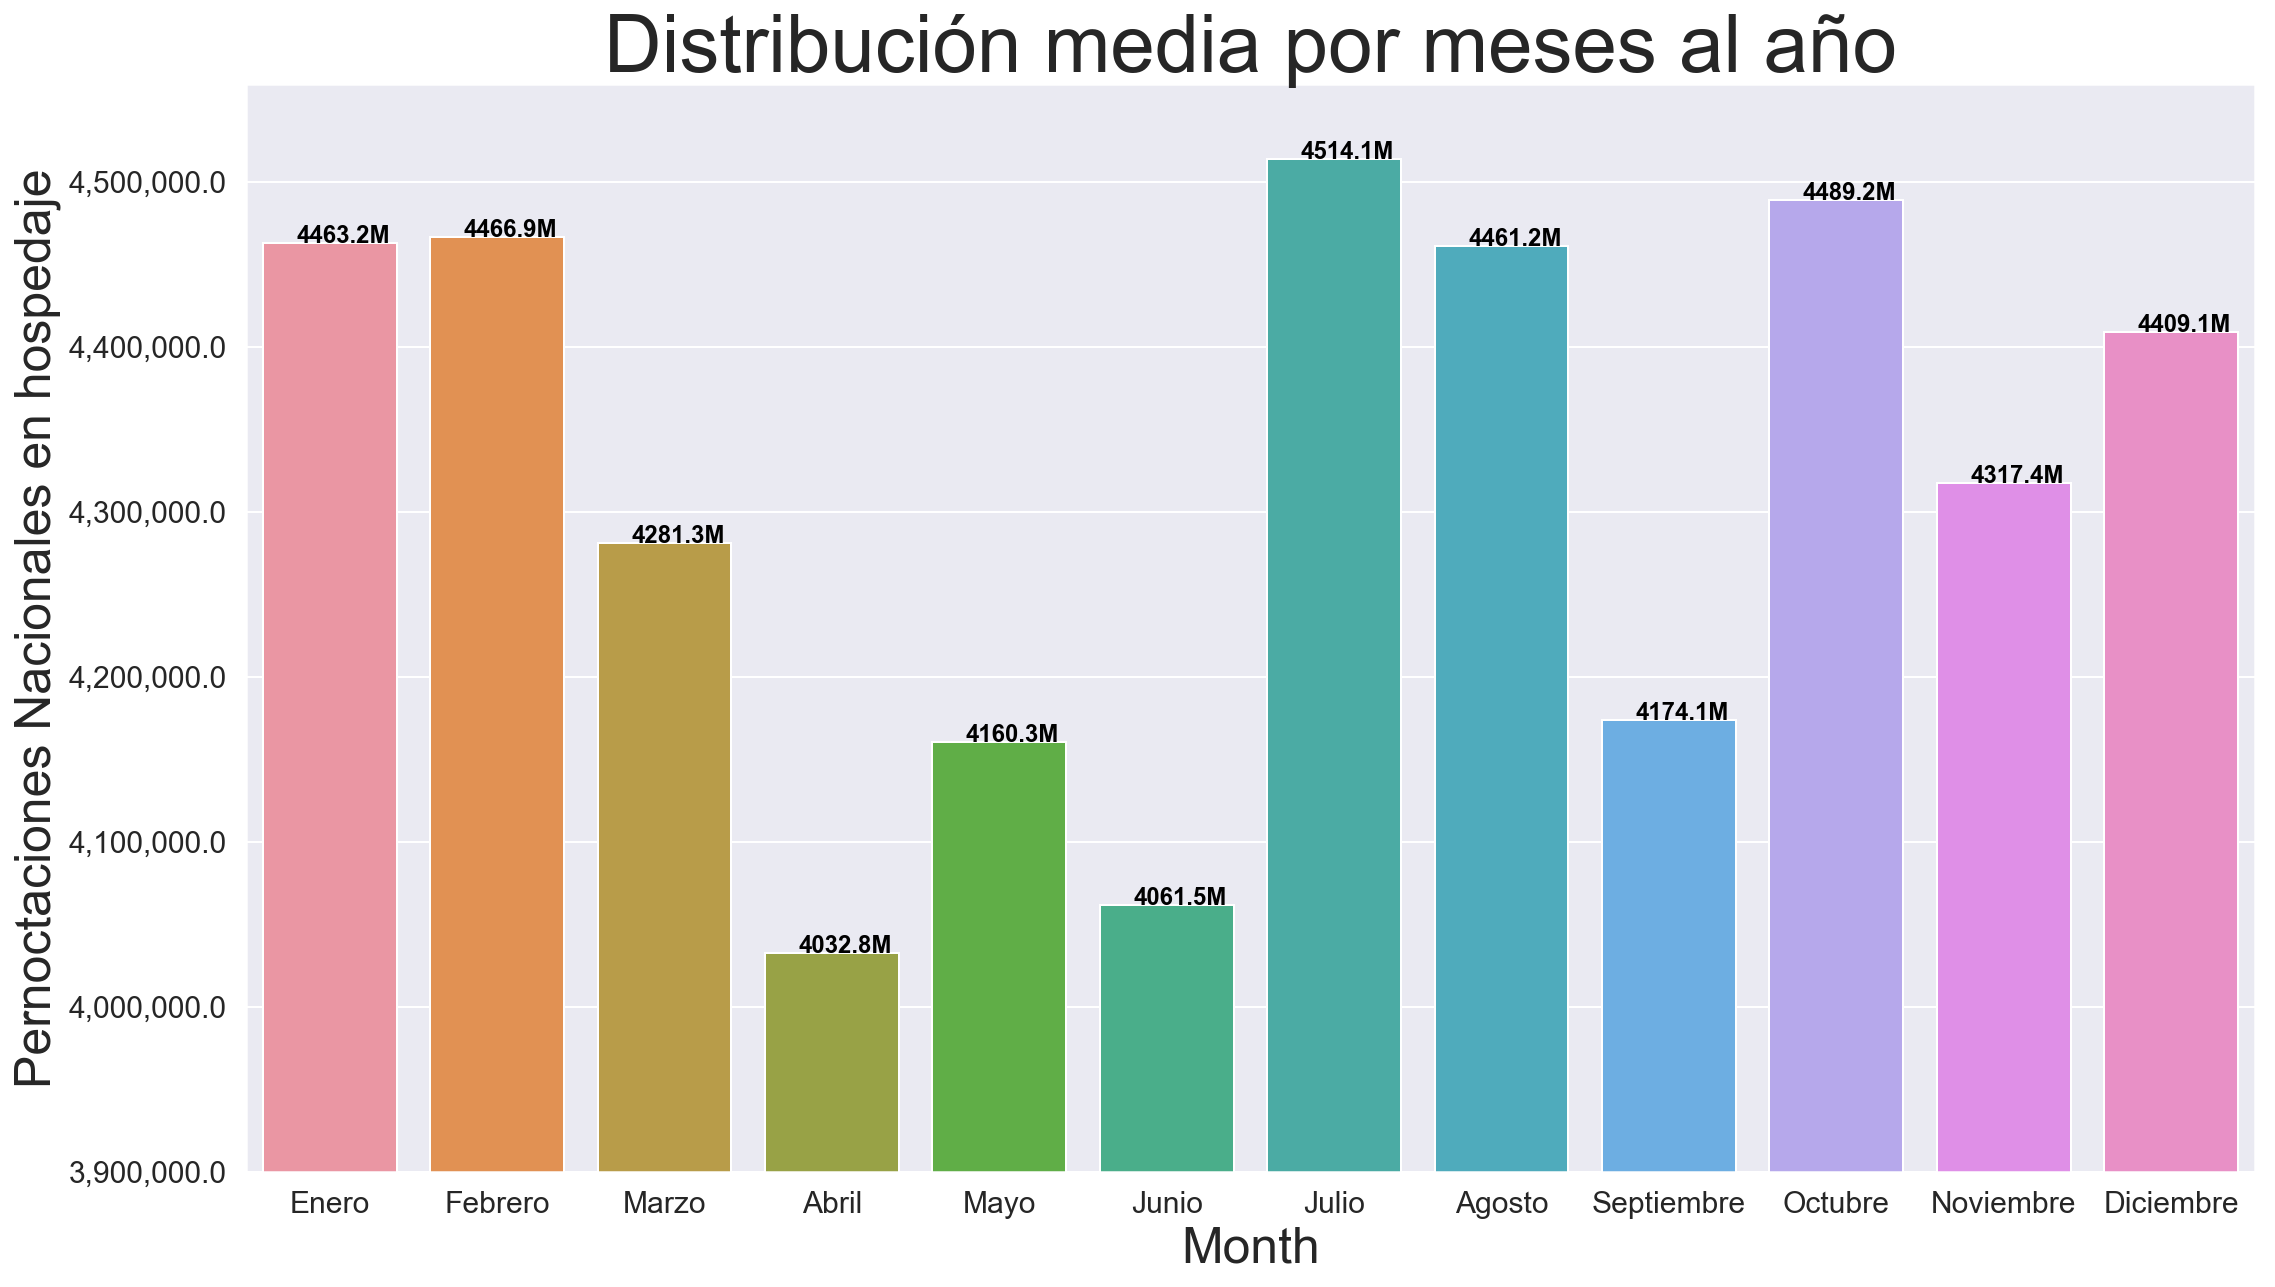

In [15]:
show_descriptive_data_by_month('rptaniomes_b.xls','Pernoctaciones Nacionales en hospedaje')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4300      0.345      1.247      0.212      -0.246       1.106
ma.L1         -0.7269      0.295     -2.467      0.014      -1.304      -0.149
ar.S.L12      -0.1150      0.152     -0.757      0.449      -0.413       0.183
sigma2       3.56e+10   3.04e-12   1.17e+22      0.000    3.56e+10    3.56e+10


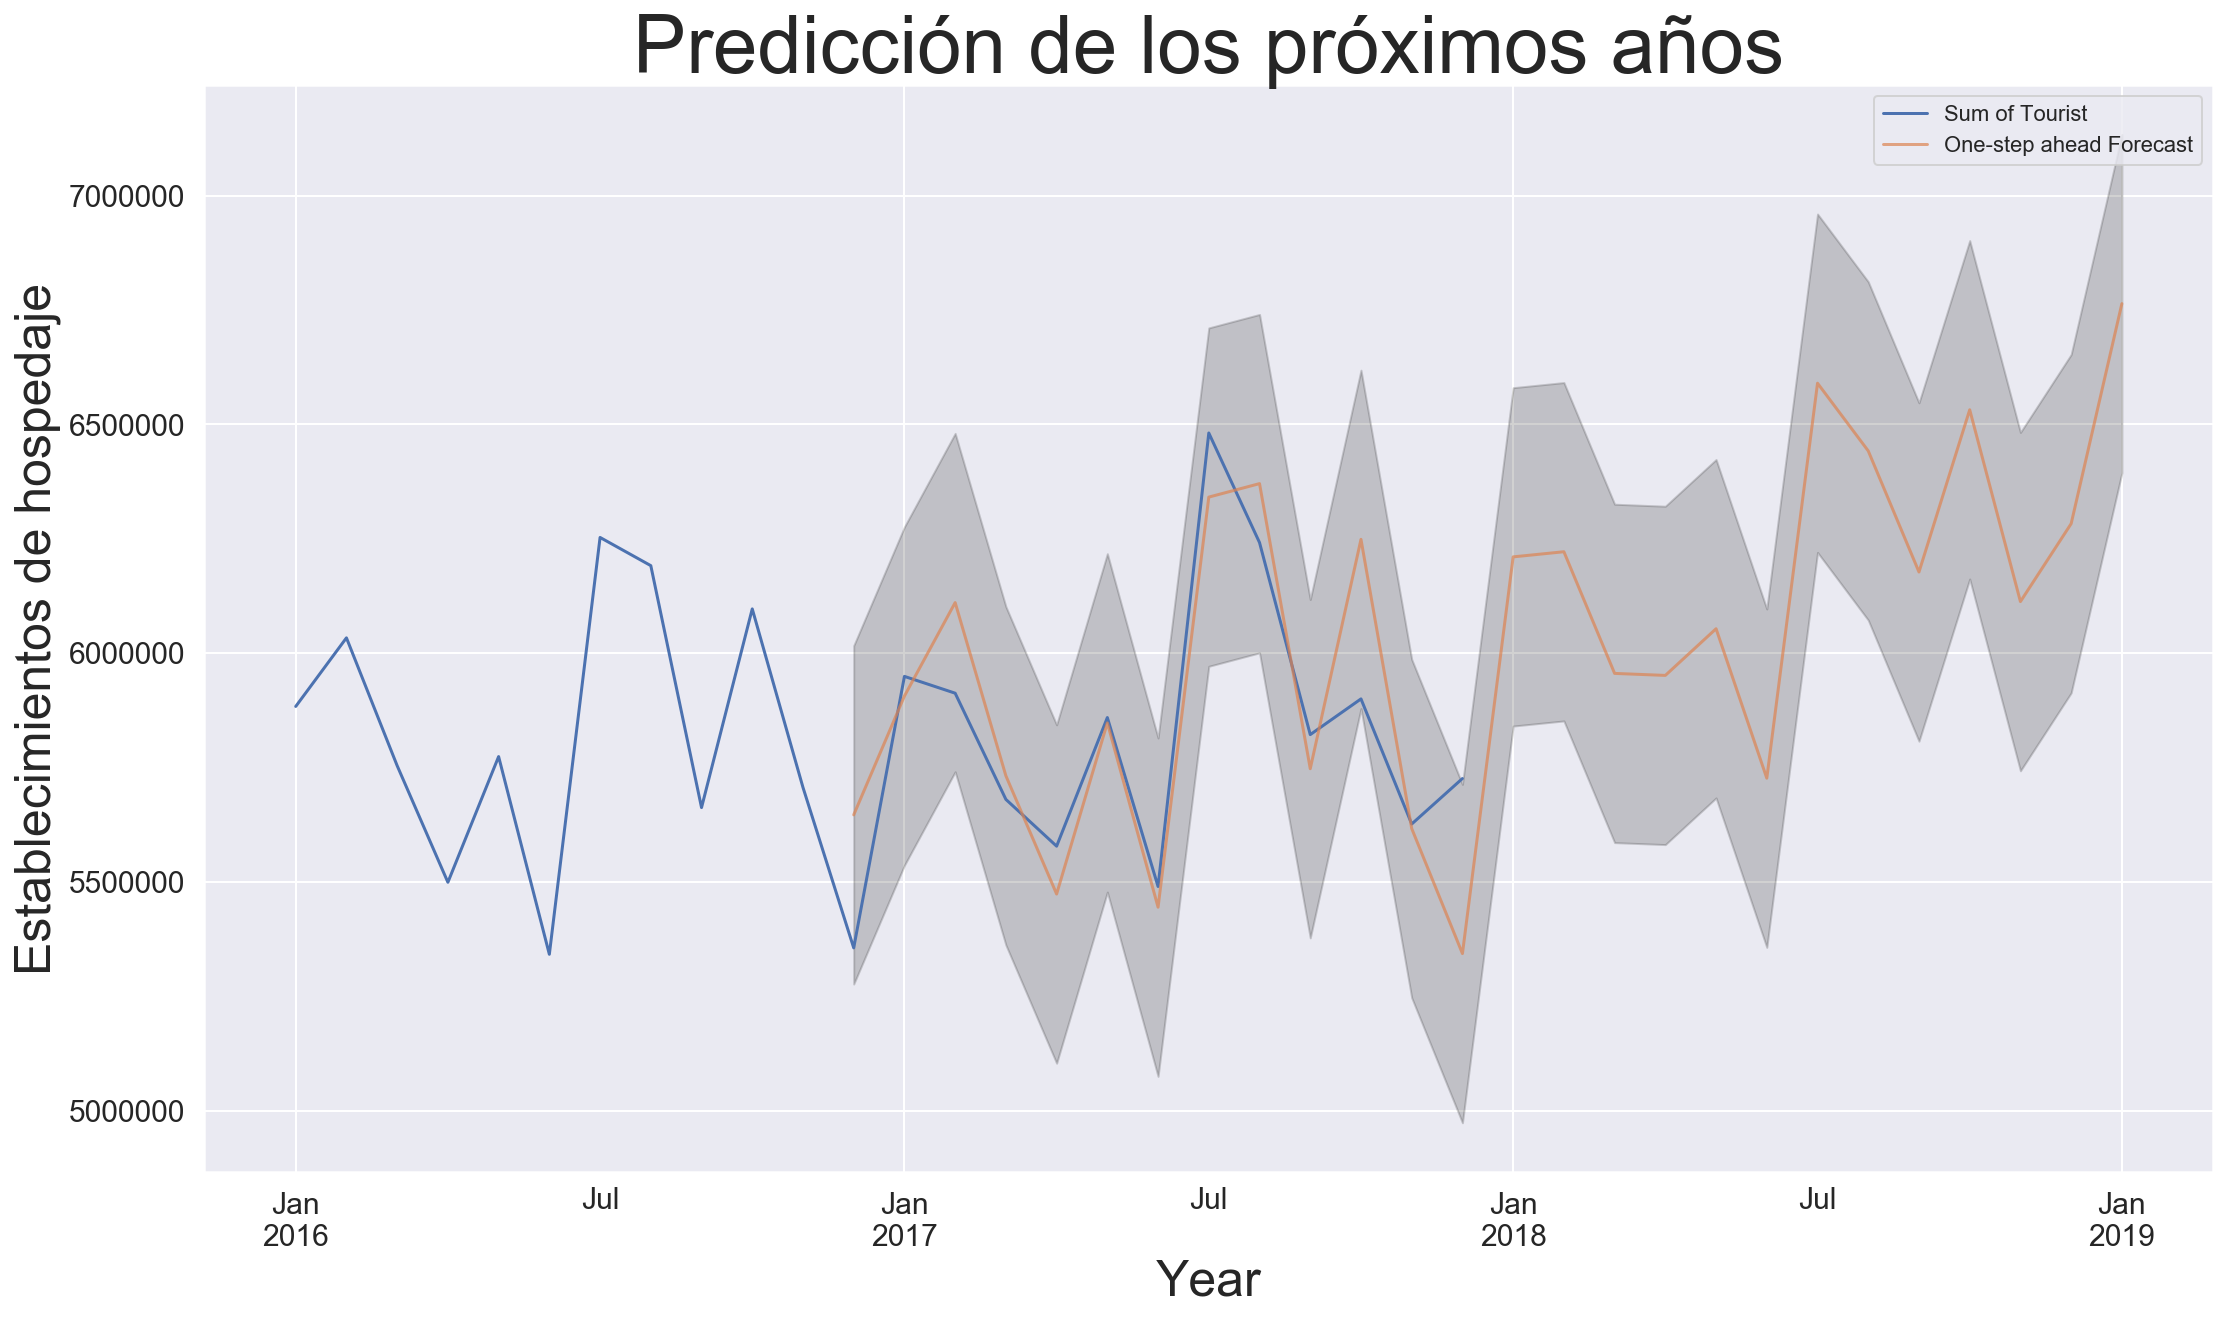

In [21]:
predict_plot('rptaniomes_a.xls','Pernoctaciones Nacionales en hospedaje')

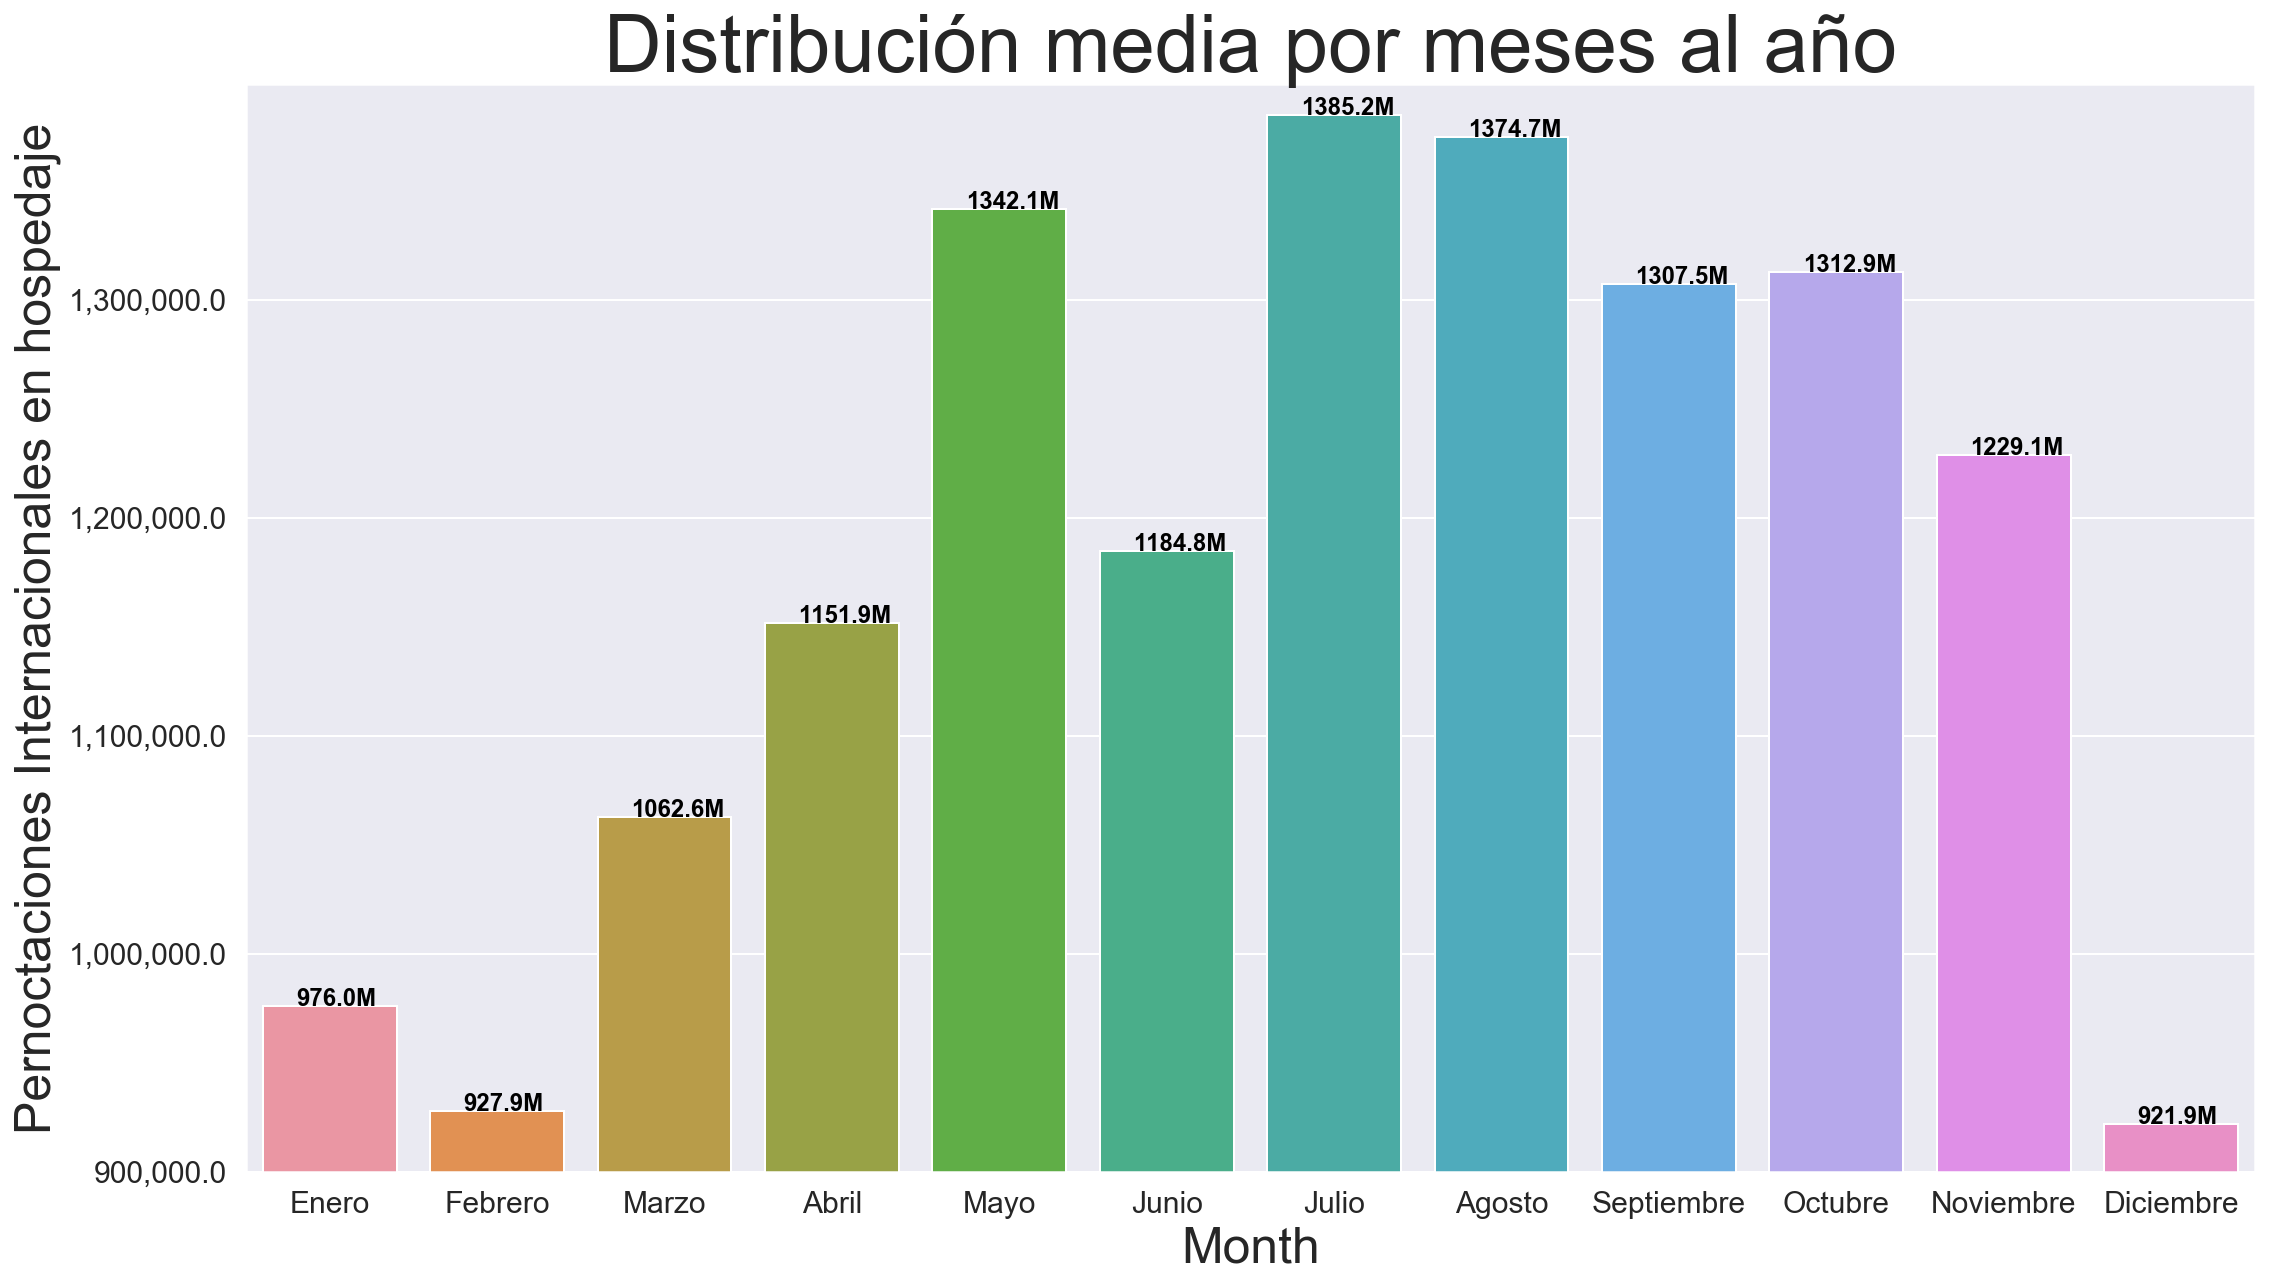

In [16]:
show_descriptive_data_by_month('rptaniomes_c.xls','Pernoctaciones Internacionales en hospedaje')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6133      1.216     -0.504      0.614      -2.997       1.771
ma.L1          0.6851      1.092      0.627      0.531      -1.456       2.826
ar.S.L12      -0.3631      0.192     -1.890      0.059      -0.740       0.013
sigma2      8.392e+09   5.19e-11   1.62e+20      0.000    8.39e+09    8.39e+09


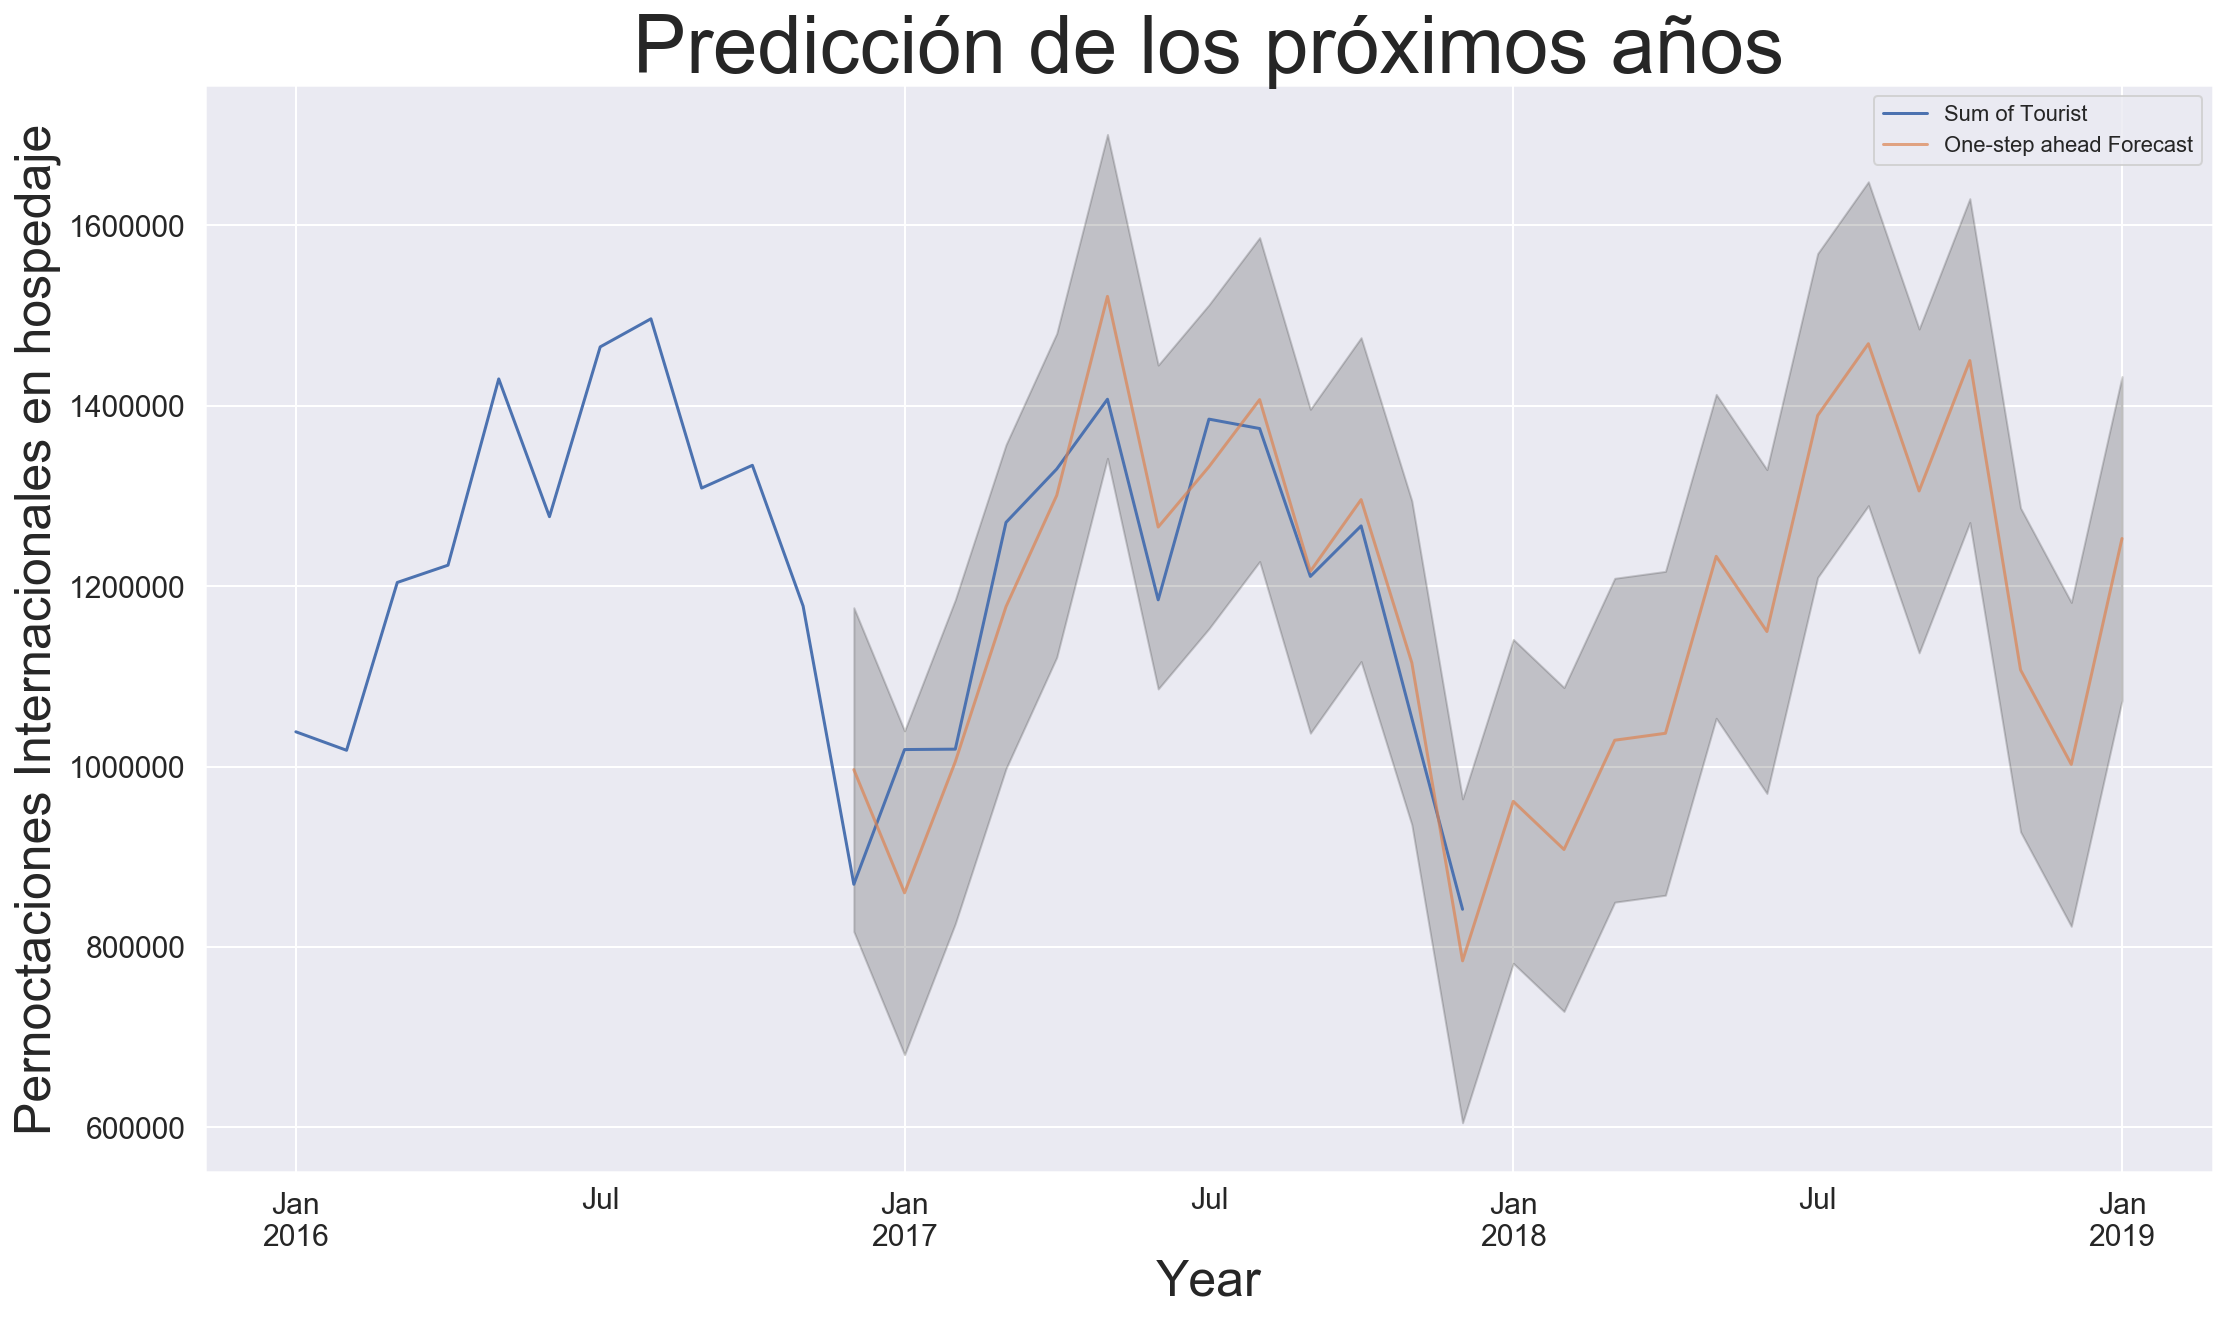

In [22]:
predict_plot('rptaniomes_c.xls','Pernoctaciones Internacionales en hospedaje')

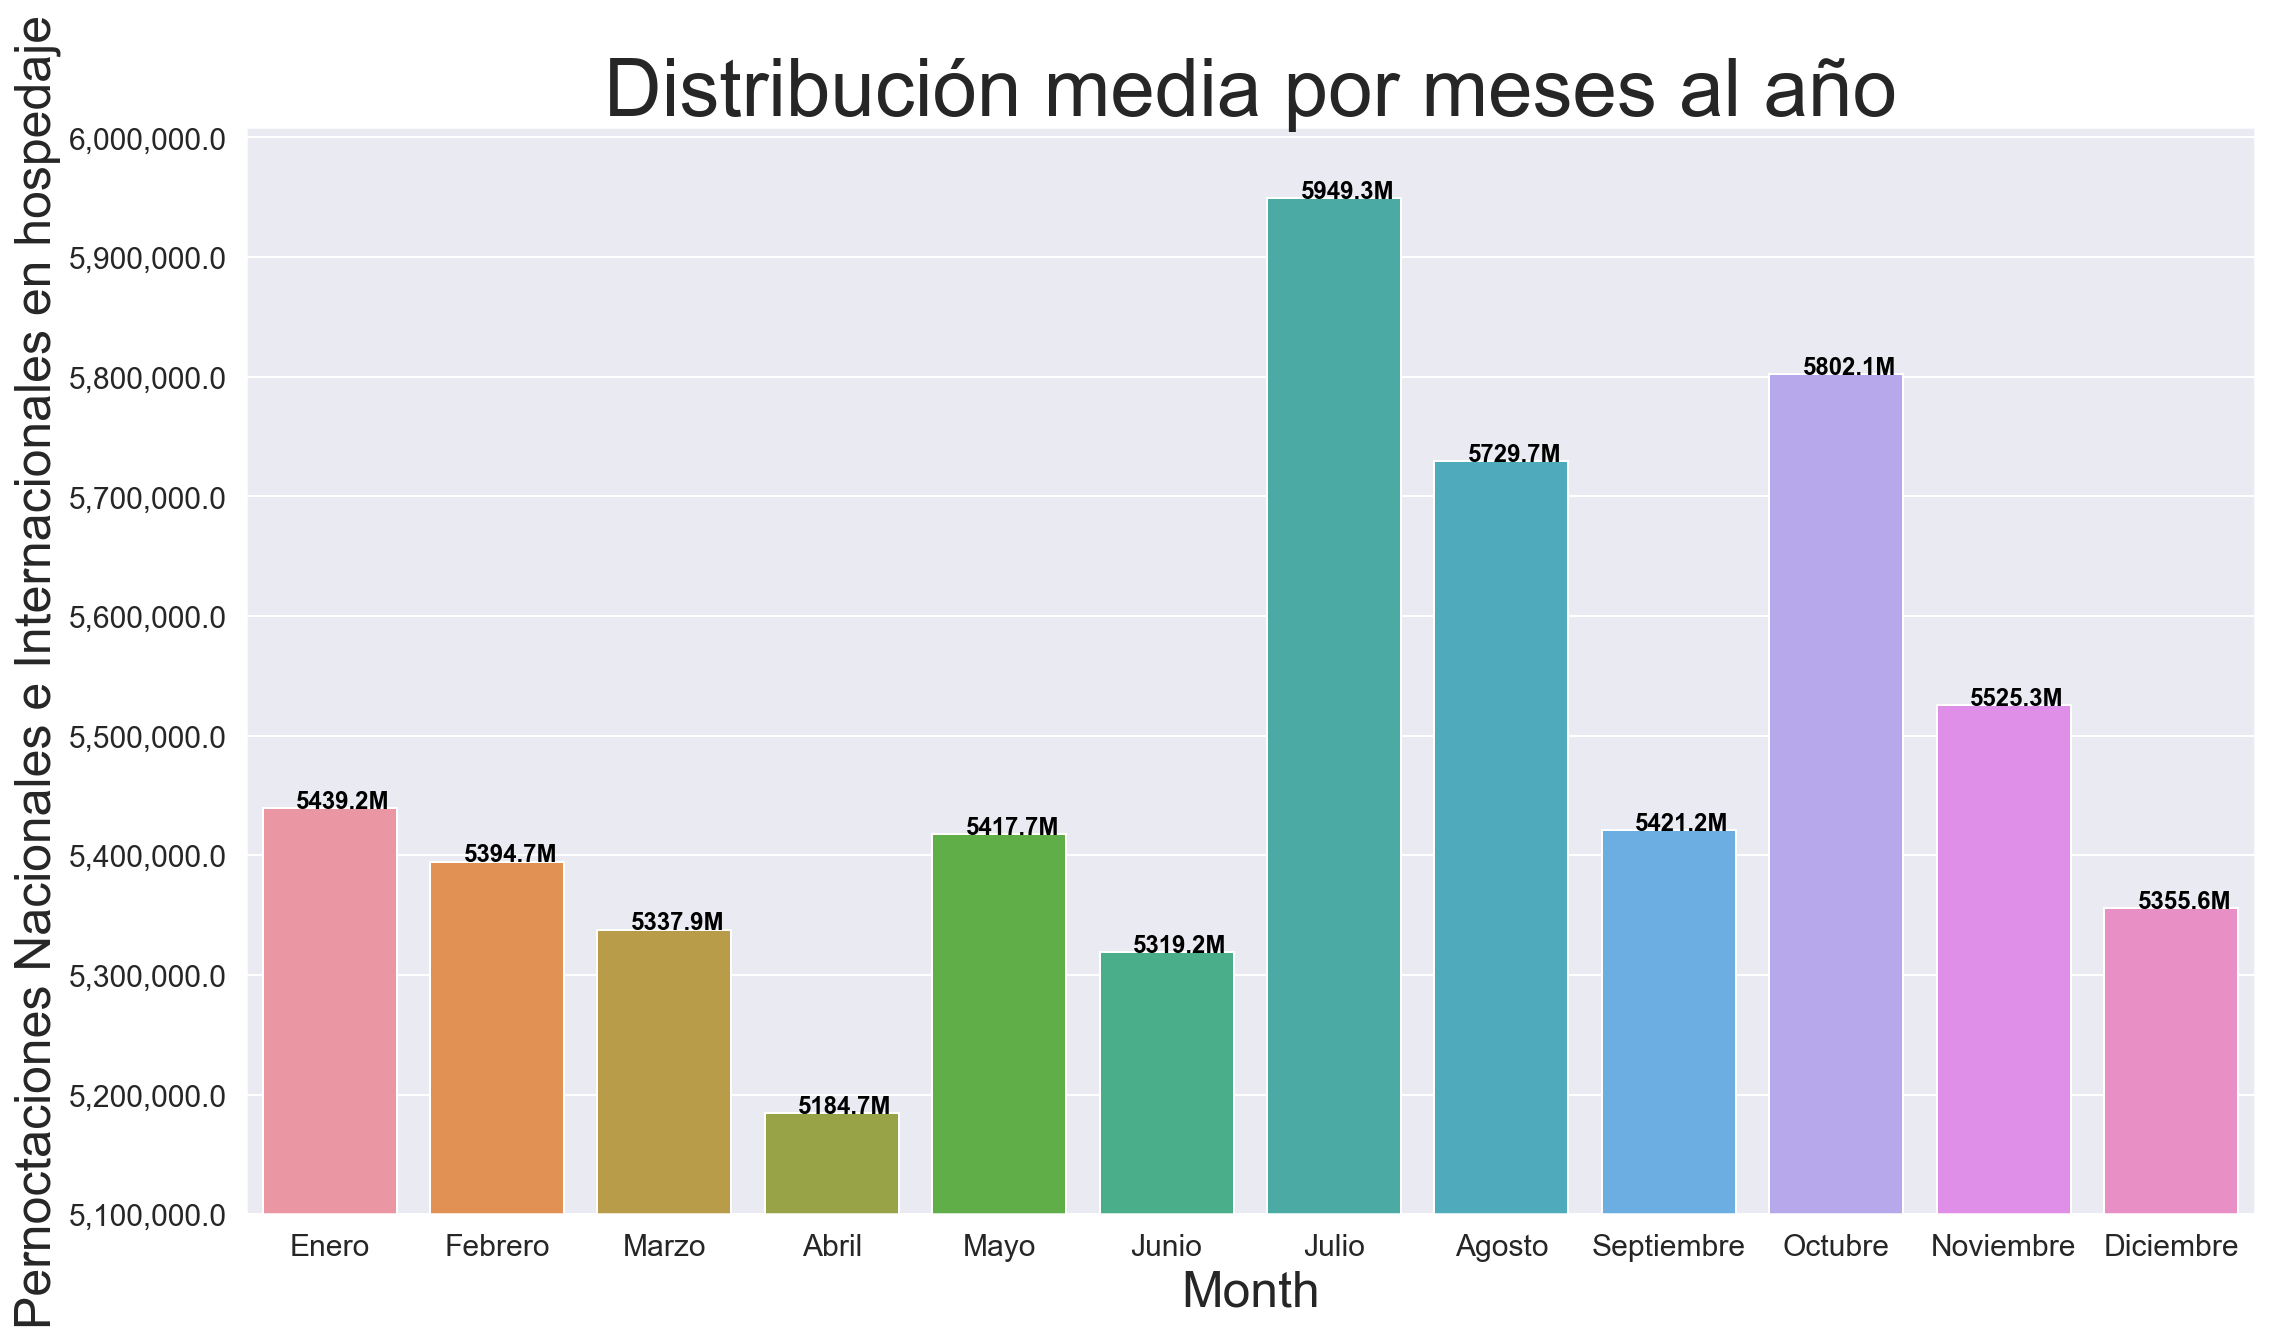

In [23]:
show_descriptive_data_by_month('rptaniomes_a.xls','Pernoctaciones Nacionales e Internacionales en hospedaje')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4300      0.345      1.247      0.212      -0.246       1.106
ma.L1         -0.7269      0.295     -2.467      0.014      -1.304      -0.149
ar.S.L12      -0.1150      0.152     -0.757      0.449      -0.413       0.183
sigma2       3.56e+10   3.04e-12   1.17e+22      0.000    3.56e+10    3.56e+10


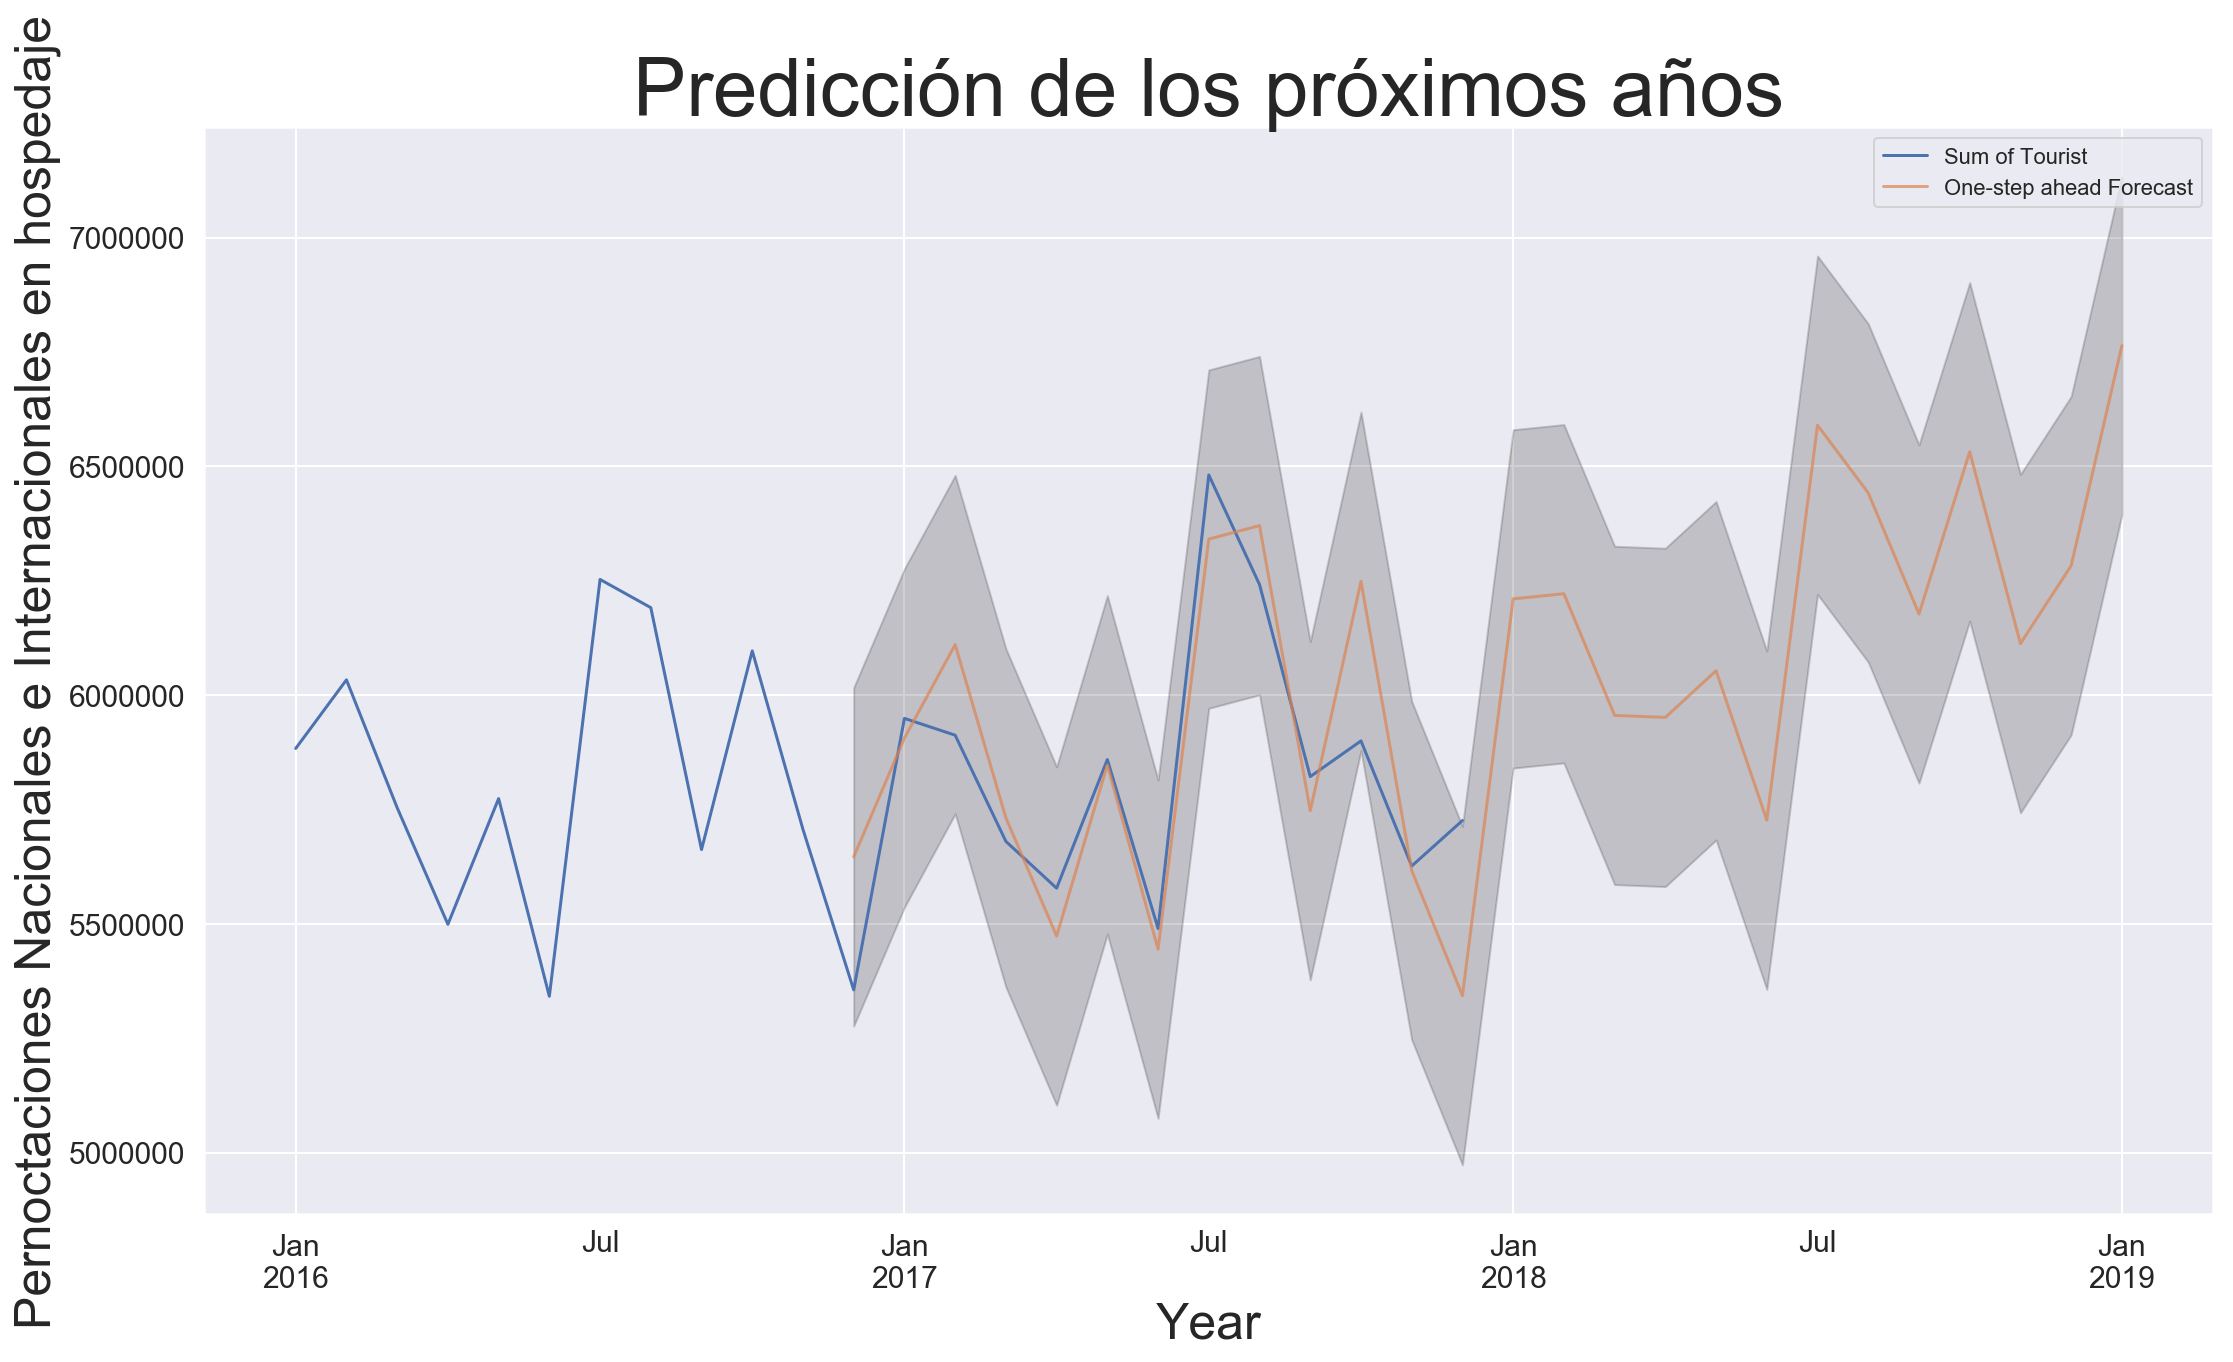

In [24]:
predict_plot('rptaniomes_a.xls','Pernoctaciones Nacionales e Internacionales en hospedaje')

In [37]:
def plot_df(df,title ='Tourist'):
    df = df.T
    dic = dict(y='Region',x='Amount')
    info = df.sum().to_frame().reset_index()
    info.columns = list(dic.values())
    ax = sns.barplot(data=info,**dic)
    for i, v in enumerate(info['Amount'].values):
        ax.text( v+v*.1 ,i+.2 , str('%.3fM'%(v/1000)), color='black', fontweight='bold')
    plt.xscale('log')
    xx, locs = plt.xticks()
    ll = ['{:,}'.format(a) for a in xx]
    plt.xticks(xx[:-1], ll[:-1])
        
def show_descriptive_data(name_file,sheet,scale='log',title ='Tourist'):
    df = pd.read_excel(name_file,sheet_name=sheet,nrows=25,
                           skiprows=3,index_col=0,)
    df = df.loc[:,df.columns.map(lambda x: x.isalnum())]
    clean_dataframe(df)
    plot_df(df,title)
    plt.xscale(scale)
    plt.title(title)
    plt.show();

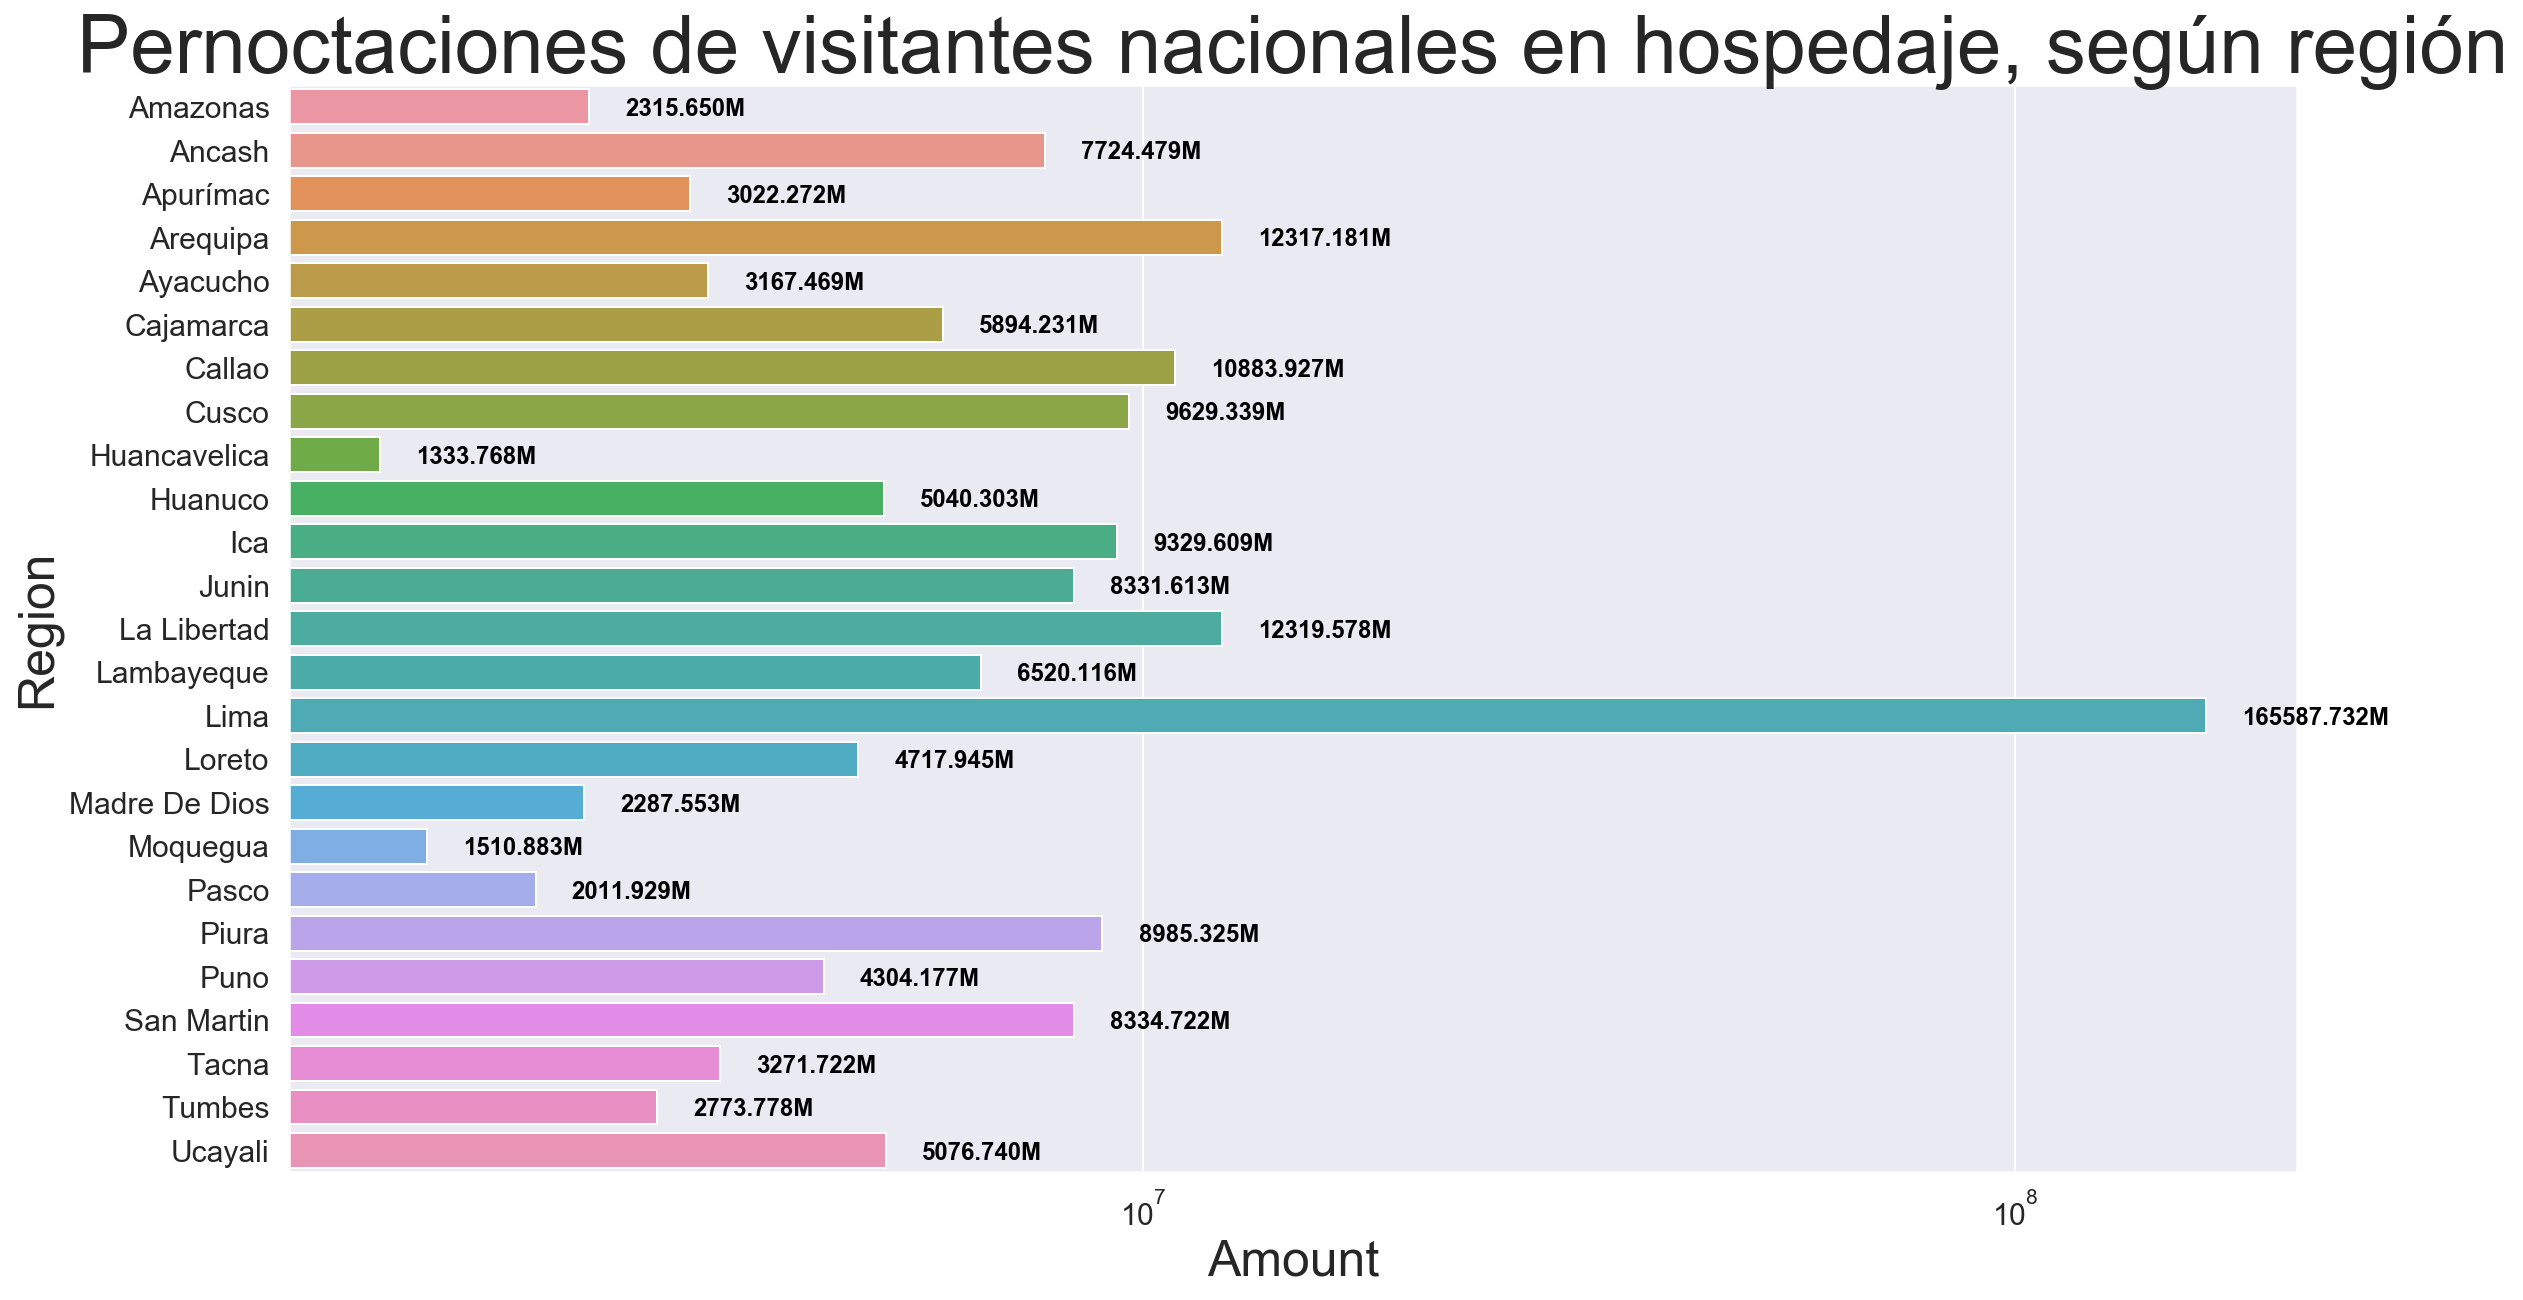

In [38]:
show_descriptive_data('rptaniomest_b.xls','rptaniomest',
                     title='Pernoctaciones de visitantes nacionales en hospedaje, según región')

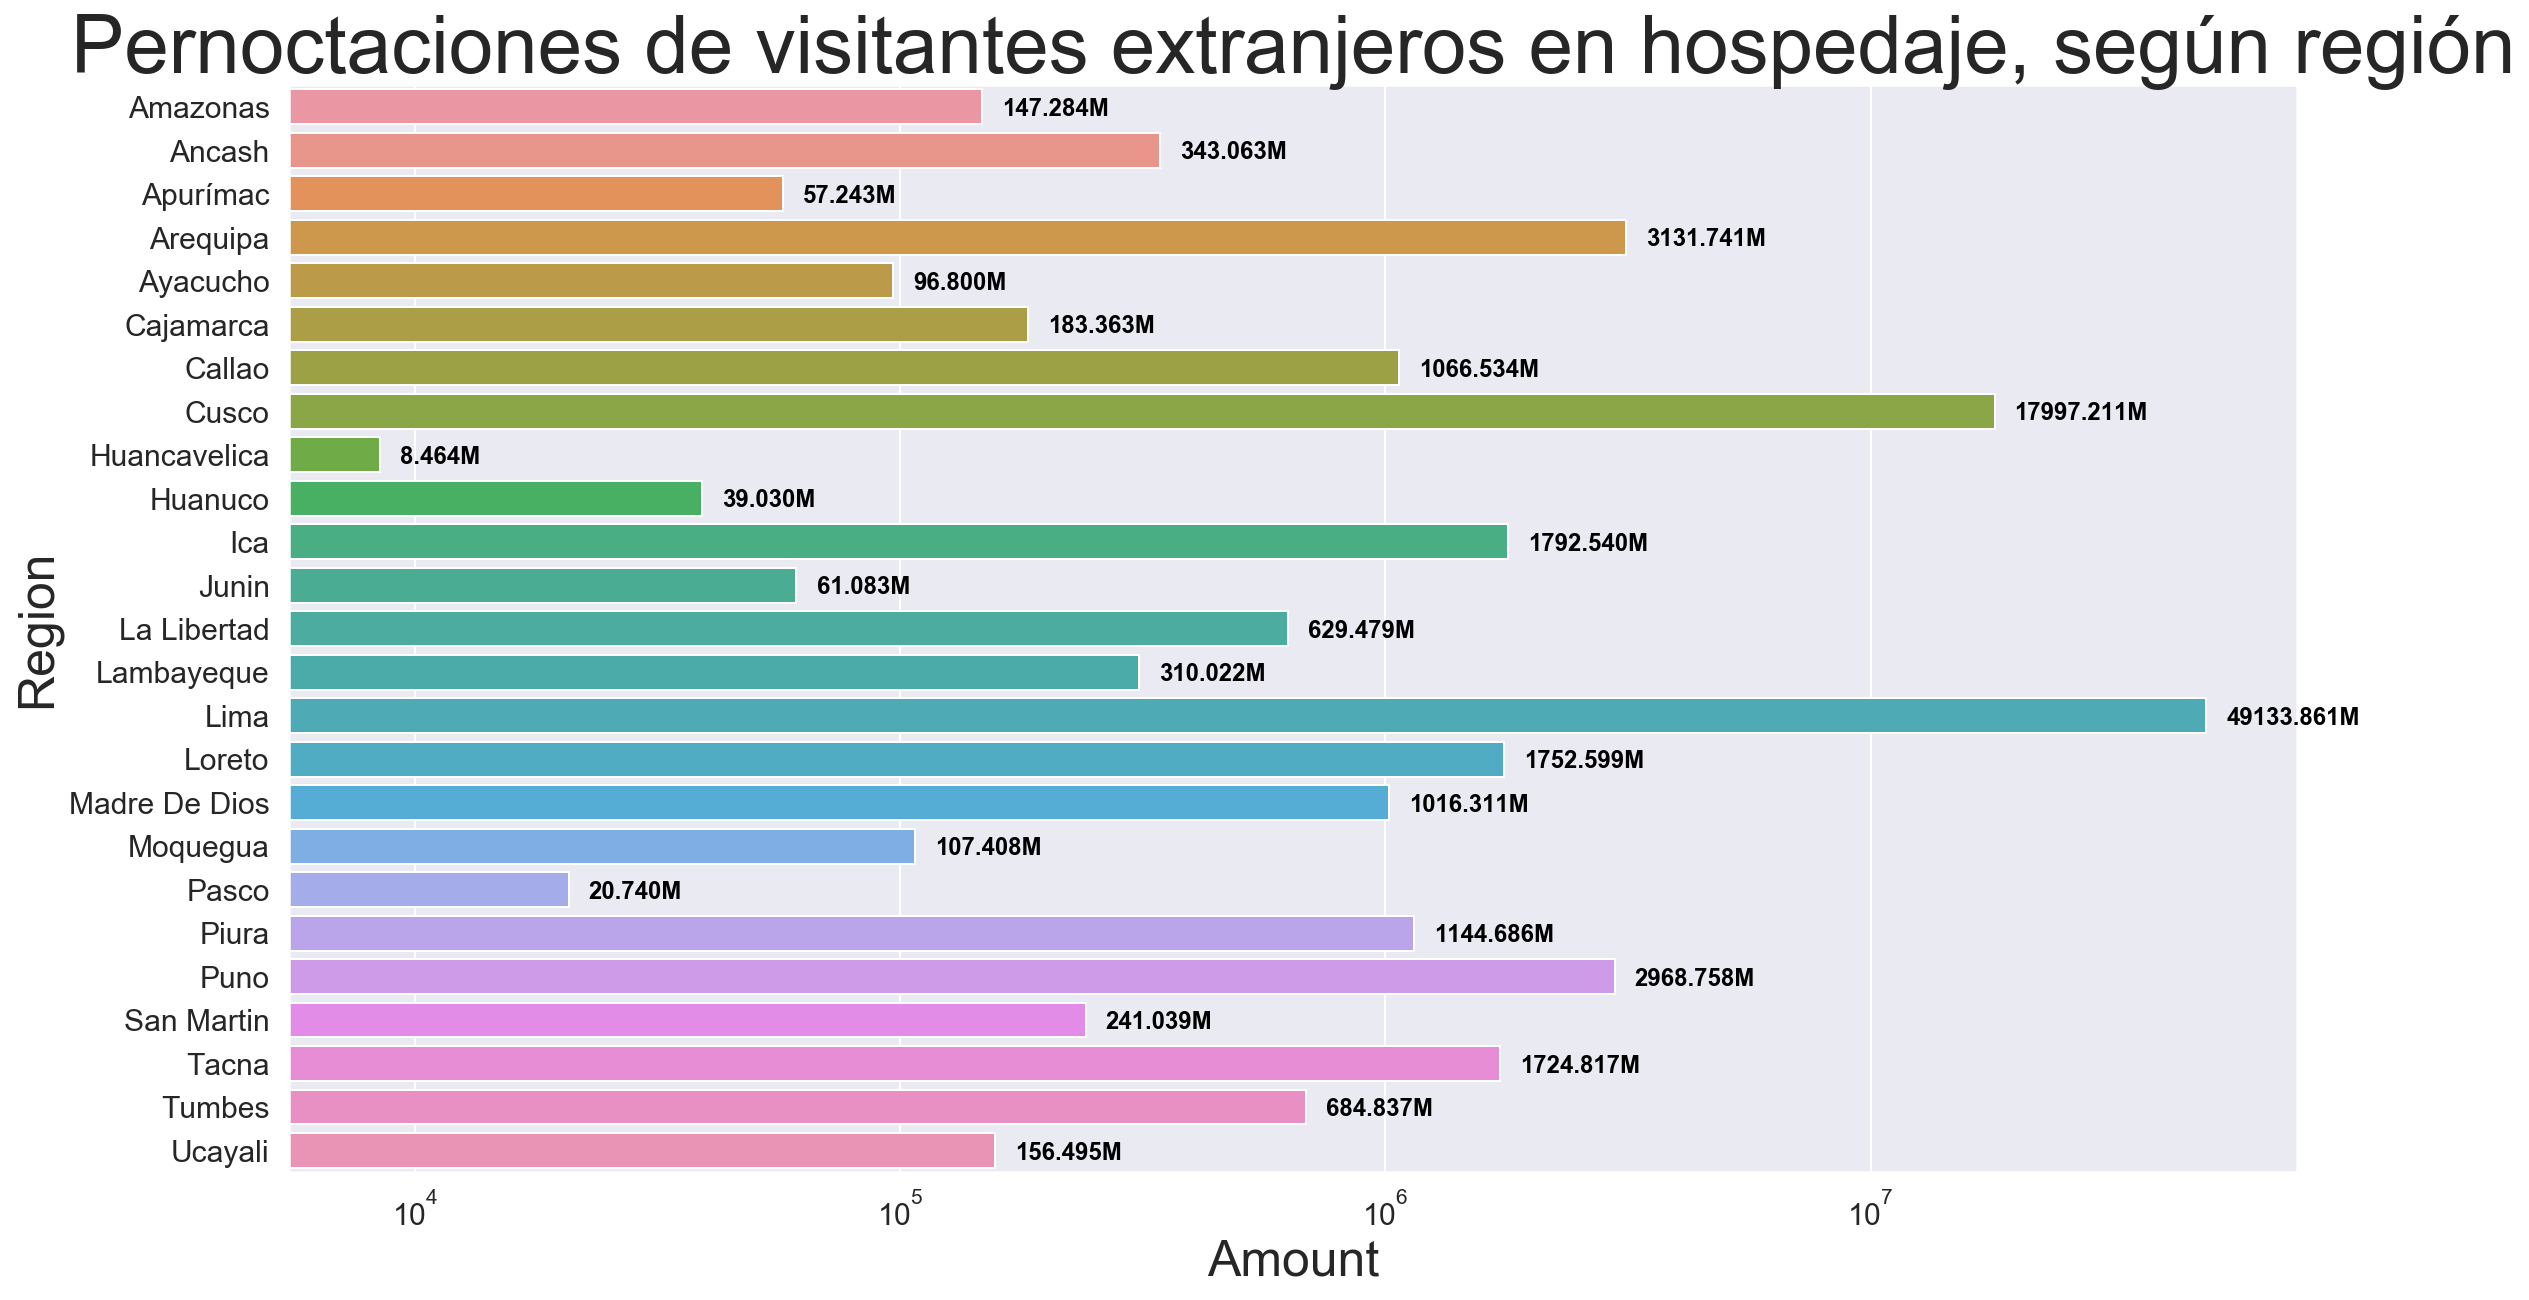

In [39]:
show_descriptive_data('rptaniomest_c.xls','rptaniomest',
                     title='Pernoctaciones de visitantes extranjeros en hospedaje, según región')

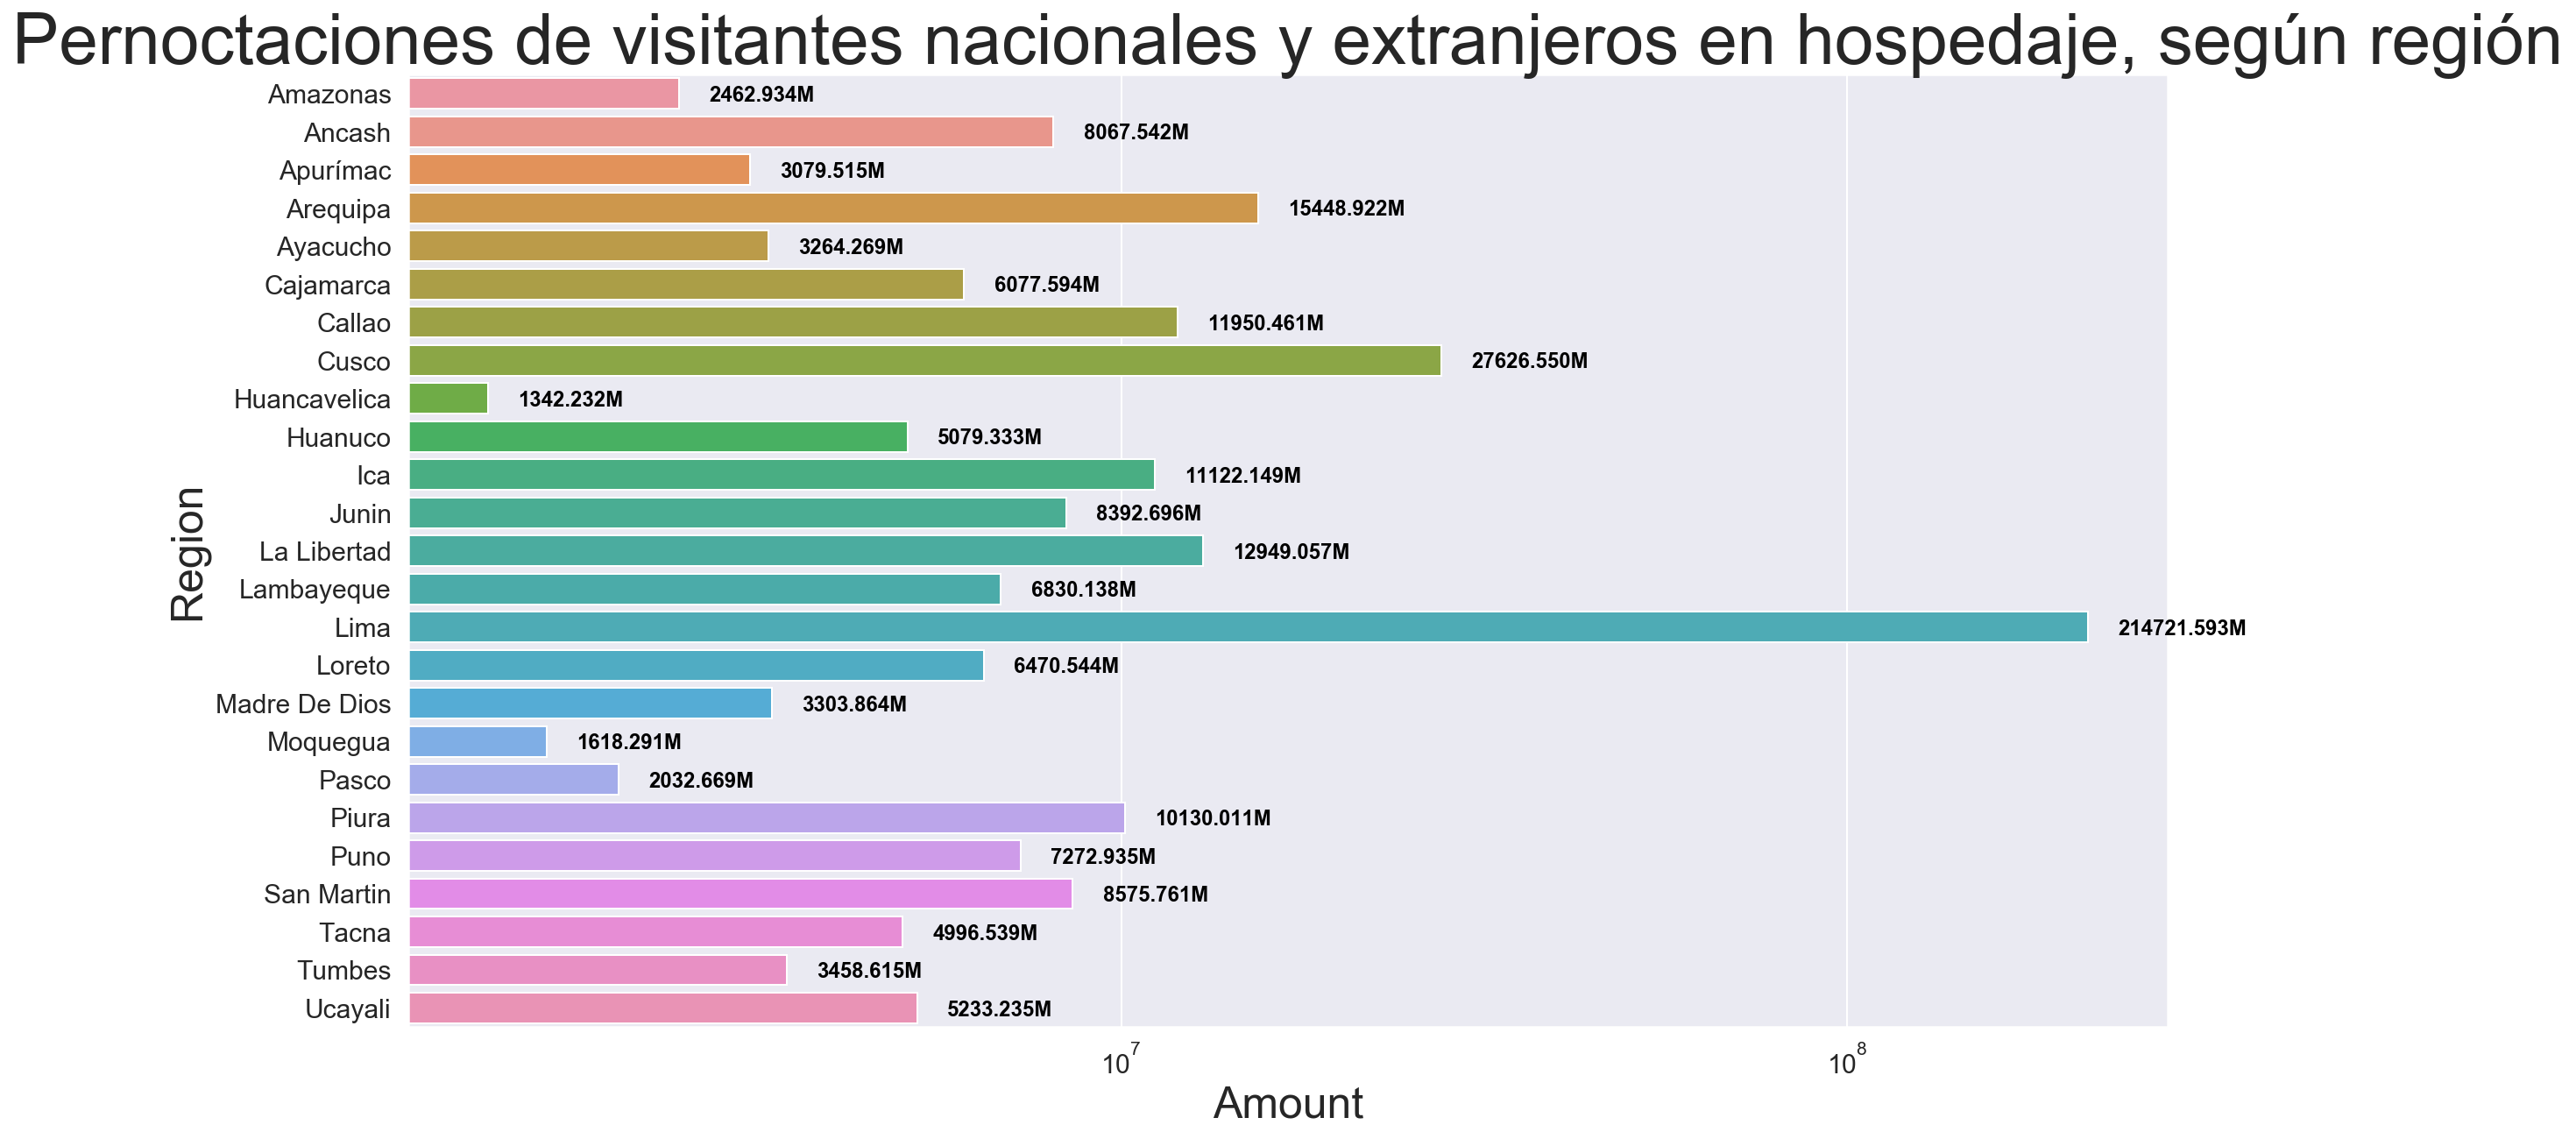

In [40]:
show_descriptive_data('rptaniomest_a.xls','rptaniomest',
                     title='Pernoctaciones de visitantes nacionales y extranjeros en hospedaje, según región')